In [1]:
import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
import pickle

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

import horus as ho

In [2]:
bs, bsh, (nfp, coils, ma, sc_fieldline) = ho.ncsx()

In [ ]:
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.show()

#### Poincare plot

In [ ]:
nfieldlines = 30
phis = [0]    #[(i / 4) * (2 * np.pi / nfp) for i in range(4)]
Rs = np.linspace(ma.gamma()[0, 0], ma.gamma()[0, 0] + 0.14, nfieldlines)
Zs = [ma.gamma()[0, 2] for i in range(nfieldlines)]
RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

In [ ]:
fig, axs = ho.poincare_simsopt(bsh, RZs, phis, sc_fieldline, tol = 1e-5)

In [ ]:
for col in axs[0,0].collections:
    col.set_color('black')
    col.set_sizes([0.5])

#### Finding fix-point

In [282]:
fig = pickle.load(open("../output/poincare_figure_ncsx.pickle", "rb"))
ax = fig.get_axes()[0]

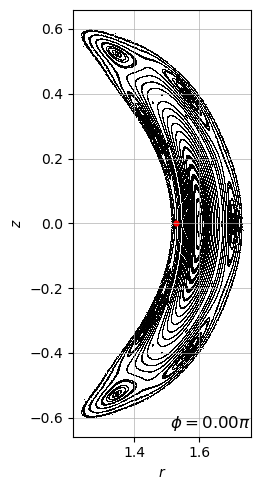

In [6]:
guess = [1.527, 0.]
ax.scatter(guess[0], guess[1], c='r', s=10)
fig

In [7]:
from pyoculus.solvers import FixedPoint
ps = ho.SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 3, bs)

In [ ]:
gamma = ho.trace(bs, 40*2*np.pi, [5.72, 0, 0.68], tol=1e-9)

In [ ]:
from mayavi import mlab
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.plot3d(gamma[0, :], gamma[1, :], gamma[2, :], tube_radius=0.01, color=(0, 0, 1))

mlab.show()

In [8]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-12

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-10
pparams['niter'] = 100

fp = FixedPoint(ps, pparams, integrator_params=iparams)
fp.compute(guess=guess, pp=3, qq=7, sbegin=1.4, send=2.0)

In [9]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]

In [10]:
results

[[1.5270055748695273, 0.0, 2.736991636379275e-05],
 [1.3628371680136853, 0.0, -0.45230962008705516],
 [1.4409463083273089, 0.0, -0.4945725332171534],
 [1.6642082327031638, 0.0, -0.21189466312613692],
 [1.6642082326959111, 0.0, 0.2118946631464027],
 [1.4409463083155352, 0.0, 0.49457253322364503],
 [1.3628371680187426, 0.0, 0.4523096200769564],
 [1.5270055748695357, 0.0, -2.736995129861146e-05]]

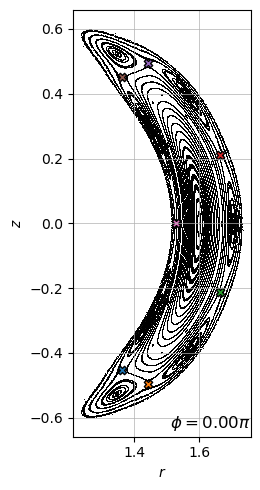

In [11]:
for rr in results:
    ax.scatter(rr[0], rr[2], marker="X", edgecolors="black", linewidths=1)
fig

#### Tracing stable and unstable manifolds

In [12]:
from scipy.integrate import solve_ivp

In [13]:
M = fp.jacobian

In [14]:
eigRes = np.linalg.eig(M)

In [15]:
lambda_u = eigRes.eigenvalues[0]
lambda_v = eigRes.eigenvalues[1]

print(lambda_u, lambda_v)

1.391678826806558 0.7185565956238701


In [226]:
u = eigRes.eigenvectors[0]
v = eigRes.eigenvectors[1]

u = u / np.linalg.norm(u)
v = v / np.linalg.norm(v)

print(u, v)

[ 0.70710678 -0.70710678] [0.70710678 0.70710678]


In [296]:
eps = np.atleast_2d(np.linspace(1e-16, 1e-14, 100)).T

In [311]:
rX = (np.array([fp.x[0], fp.z[0]], ndmin=2).T @ np.ones((1, eps.shape[0]))).T
RZs = rX + (eps @ np.atleast_2d(u))

In [ ]:
def Bfield_2D(t, rzs):
    rzs = rzs.reshape((-1, 2))
    rphizs = np.ascontiguousarray(np.vstack((rzs[:, 0], (t % (2*np.pi))*np.ones(rzs.shape[0]), rzs[:, 1])).T)
    bs.set_points_cyl(rphizs)
    bs_Bs = bs.B()
    
    # Bs = np.zeros((rphizs.shape[0], 2))
    # for i, (position, B) in enumerate(zip(rphizs, bs_Bs)):
    #     B = inv_Jacobian(*position) @ B.reshape(3, -1)
    #     Bs[i] = np.array([B[0, 0] / B[1, 0], B[2, 0] / B[1, 0]])

    # return np.array(Bs).flatten()

In [ ]:
%timeit Bfield_2D(0, RZs.flatten())

856 µs ± 170 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [347]:
def inv_Jacobian(R, phi, _):
    return np.array([
            [np.cos(phi), -np.sin(phi)/R, 0], 
            [np.sin(phi), np.cos(phi)/R, 0], 
            [0,0,1]
        ])

def poincare_ivp_2d(bs, RZstart, phis, **kwargs):
    options = {
        "rtol": 1e-7,
        "atol": 1e-8,
        "nintersect": 10,
        "method": "DOP853",
        "nfp": 1,
        "mpol": 1,
    }
    options.update(kwargs)

    def Bfield_2D(t, rzs):
        print(t)
        rzs = rzs.reshape((-1, 2))
        rphizs = np.ascontiguousarray(np.vstack((rzs[:, 0], (t % (2*np.pi))*np.ones(rzs.shape[0]), rzs[:, 1])).T)
        bs.set_points_cyl(rphizs)
        Bs = list()
        for position, B in zip(rphizs, bs.B()):
            B = inv_Jacobian(*position) @ B.reshape(3, -1)
            Bs.append(np.array([B[0, 0] / B[1, 0], B[2, 0] / B[1, 0]]))

        return np.array(Bs).flatten()
    
    # setup the phis of the poincare sections
    phis = np.unique(np.mod(phis, 2*np.pi/options['nfp']))
    phis.sort()

    # setup the evaluation points for those sections
    phi_evals = np.array([phis+options['mpol']*2*np.pi*i/options['nfp'] for i in range(options['nintersect']+1)])

    print(phi_evals[-1,-1])
    out = solve_ivp(
        Bfield_2D,
        [0, phi_evals[-1,-1]],
        RZstart.flatten(),
        t_eval=phi_evals.flatten(),
        method=options["method"],
        atol=options["atol"],
    )

    return out

In [373]:
out = poincare_ivp_2d(bs, RZs, phis, nintersect=10, mpol=1, nfp=3, atol=1e-12, rtol=1e-1)

20.943951023931955
0.0
1.491438664461773e-06
7.844990038787085e-06
1.1767485058180629e-05
1.7651227587270943e-05
4.2006318991199975e-05
4.9714622148725765e-05
3.7285966611544326e-05
4.589042044497764e-05
9.713472327520265e-05
8.948631986770638e-05
0.0001278375998110091
0.0001491438664461773
0.0001491438664461773
1.491438664461773e-05
2.982877328923546e-05
0.00011600078501369345
0.00022759376683404814
0.0002668187170279836
0.0003256561423188867
0.000569207056358177
0.0006462900879334348
0.0005220035325616205
0.0006080480708959535
0.0011204910991982038
0.001044007065123241
0.001427519864556268
0.0016405825309079502
0.0016405825309079502
0.0024250815347866585
0.002817331036726013
0.0034057052896350444
0.005841214430027947
0.006612044745780526
0.0053691791920623825
0.006229624575405713
0.011354054858428216
0.010589214517678587
0.014424342512008859
0.01655496917552568
0.01655496917552568
0.024399959214312764
0.028322454233706308
0.034206196762796626
0.05856128816672565
0.06626959132425143
0

KeyboardInterrupt: 

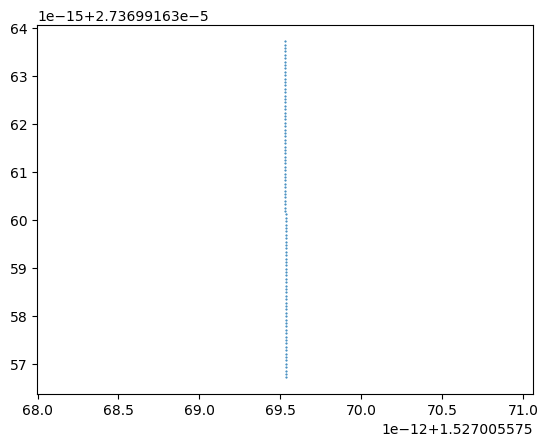

In [342]:
for yy in out.y.T:
    yy = yy.reshape(-1, 2)
    plt.scatter(yy[:, 0], yy[:, 1], marker=".", s=1)

# plt.xlim(1.2, 1.8)
# plt.ylim(-0.7, 0.7)

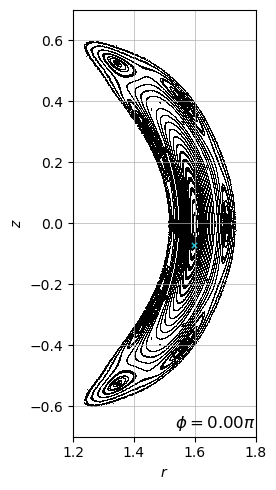

In [287]:
ax.set_xlim(1.2, 1.8)
ax.set_ylim(-0.7, 0.7)

fig

#### Finding fix-point

In [ ]:
fig = pickle.load(open("../output/poincare_figure_GYM000+1750_black.pickle", "rb"))
ax = fig.get_axes()[0]

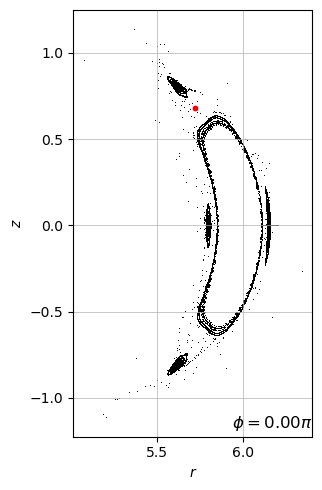

In [ ]:
guess = [5.72, 0.68]
ax.scatter(guess[0], guess[1], c='r', s=10)
fig

In [ ]:
from pyoculus.solvers import FixedPoint
ps = ho.SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 5, bs)

In [ ]:
gamma = ho.trace(bs, 40*2*np.pi, [5.72, 0, 0.68], tol=1e-9)

In [ ]:
from mayavi import mlab
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.plot3d(gamma[0, :], gamma[1, :], gamma[2, :], tube_radius=0.01, color=(0, 0, 1))

mlab.show()

In [ ]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-7

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-7
pparams['niter'] = 100

fp = FixedPoint(ps, pparams, integrator_params=iparams)
fp.compute(guess=guess, pp=5, qq=4, sbegin=5.2, send=6.2, tol = 1e-8)

In [ ]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]

In [ ]:
results

[[5.69648610524311, 0.0, 0.5895406208454734],
 [5.765996193238455, 0.0, -0.366414113907058],
 [5.815089450907344, 0.0, -0.683630046886361],
 [6.052241336689595, 0.0, 0.36051546592529704],
 [5.732760802630126, 0.0, 0.6037668123825095]]

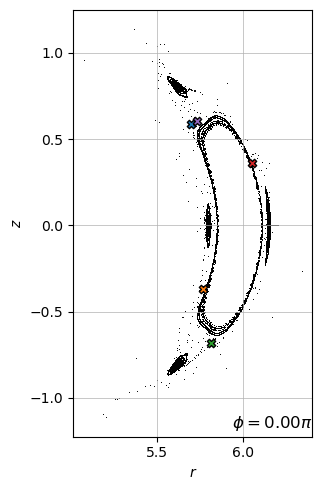

In [ ]:
for rr in results:
    ax.scatter(rr[0], rr[2], marker="X", edgecolors="black", linewidths=1)
fig

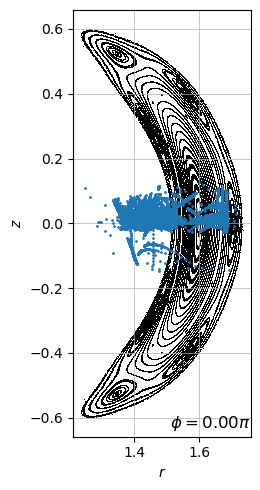

In [179]:
rr = np.array(record)
ax.plot(rr[:, 0], rr[:, 1], "o", markersize=1)
fig

In [ ]:
for rr in record:
    plt.scatter(rr[0], rr[2], marker="x")

In [ ]:
fig = pickle.load(open("../output/poincare_figure_GYM000+1750_black.pickle", "rb"))

In [ ]:
ax = fig.get_axes()[0]
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'black']

for i, p in enumerate(fieldlines_phi_hits):
    for rr in p:
        ax.scatter(rr[2], rr[4], marker="X", color=colors[i % len(colors)], linewidths=1)

In [ ]:
fig

In [ ]:
for rr in r:
    plt.scatter(rr[0], rr[1], marker="X", edgecolors="black", linewidths=1)


In [ ]:
ho.poincare(bs, np.atleast_2d(r[1]), [0], sc_fieldline, plot = False, tmax = 22, tol = 1e-10)

In [ ]:
r.append(np.array([5.95395959e+00, 5.85198574e-01]))

In [ ]:
for rr in r:
    plt.scatter(rr[0], rr[1], marker="X", edgecolors="black", linewidths=1)